<a href="https://colab.research.google.com/github/prasanth5reddy/D2L/blob/master/GANs/generative_adversarial_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
w_dir = '/content/drive/My Drive/Colab/D2L.AI/'
sys.path.append(w_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing Libraries

In [2]:
!pip uninstall mxnet && pip install mxnet-cu100

Importing Libraries

In [0]:
%matplotlib inline
import d2l
from mxnet import nd, gluon, autograd, init
from mxnet.gluon import nn

Generate some "real" data

In [4]:
X = nd.random.normal(shape=(1000, 2))
A = nd.array([[1, 2], [-0.1, 0.5]])
b = nd.array([1, 2])
data = nd.dot(X, A) + b
data.shape

(1000, 2)

The covariance matrix is 
[[1.01 1.95]
 [1.95 4.25]]
<NDArray 2x2 @cpu(0)>


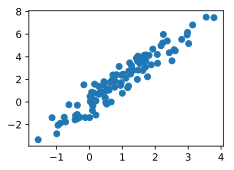

In [5]:
d2l.set_figsize((3.5, 2.5))
d2l.plt.scatter(data[:100, 0].asnumpy(), data[:100, 1].asnumpy());
print("The covariance matrix is", nd.dot(A.T, A))

In [0]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

Generator

In [0]:
net_G = nn.Sequential()
net_G.add(nn.Dense(2))

Discriminator

In [0]:
net_D = nn.Sequential()
net_D.add(nn.Dense(5, activation='tanh'),
          nn.Dense(3, activation='tanh'),
          nn.Dense(1))

Training

In [0]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
  batch_size = X.shape[0]
  ones = nd.ones((batch_size,), ctx=X.context)
  zeros = nd.zeros((batch_size,), ctx=X.context)
  with autograd.record():
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Don't need to compute gradient for net_G, detach it from computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones) + loss(fake_Y, zeros)) / 2
  loss_D.backward()
  trainer_D.step(batch_size)
  return loss_D.sum().asscalar()

In [0]:
def update_G(Z, net_D, net_G, loss, trainer_G):
  batch_size = Z.shape[0]
  ones = nd.ones((batch_size), ctx=Z.context)
  with autograd.record():
    # we could reuse this from update_D
    fake_X = net_G(Z)
    # This is needed as net_D is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones)
  loss_G.backward()
  trainer_G.step(batch_size)
  return loss_G.sum().asscalar()

In [0]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
  loss = gluon.loss.SigmoidBCELoss()
  net_D.initialize(init=init.Normal(0.02), force_reinit=True)
  net_G.initialize(init=init.Normal(0.02), force_reinit=True)
  trainer_D = gluon.Trainer(net_D.collect_params(), 'adam', {'learning_rate': lr_D})
  trainer_G = gluon.Trainer(net_G.collect_params(), 'adam', {'learning_rate': lr_D})
  animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5,5),
                            legend=['generator', 'discriminator'])
  animator.fig.subplots_adjust(hspace=0.3)
  for epoch in range(1, num_epochs):
    timer = d2l.Timer()
    metric = d2l.Accumulator(3)
    for X in data_iter:
      batch_size = X.shape[0]
      Z = nd.random.normal(0, 1, shape=(batch_size, latent_dim))
      metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                 update_G(Z, net_D, net_G, loss, trainer_G),
                 batch_size)
    Z = nd.random.normal(0, 1, shape=(100, latent_dim))
    fake_X = net_G(Z).asnumpy()
    animator.axes[1].cla()
    animator.axes[1].scatter(data[:,0], data[:,1])
    animator.axes[1].scatter(fake_X[:,0], fake_X[:,1])
    animator.axes[1].legend(['real', 'generated'])
    #show the losses
    loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
    animator.add(epoch, (loss_D, loss_G))
  print('loss_D %.3f, loss_G %.3f, %d examples/sec' % (
        loss_D, loss_G, metric[2]/timer.stop()))


loss_D 0.693, loss_G 0.693, 1062 examples/sec


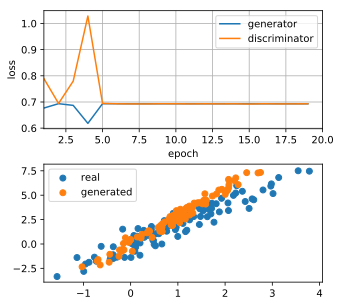

In [12]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data[:100].asnumpy())